In [282]:
import pnet_loader
import util
import torch
import numpy as np
import random
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
import pandas as pd

In [284]:
mutations_dict = {"3'Flank": 'Silent',
                  "5'Flank": 'Silent',
                  "5'UTR": 'Silent',
                  "3'UTR": 'Silent',
                  "IGR": 'Silent',
                  "Intron": 'Silent',
                  "lincRNA": 'Silent',
                  "RNA": 'Silent',
                  "Silent": 'Silent',
                  "non_coding_transcript_exon": 'Silent',
                  "upstream_gene": 'Silent',
                  "Splice_Region": 'Silent',
                  "Targeted_Region": 'Silent',
                  'Splice_Site': 'LOF',
                  'Nonsense_Mutation': 'LOF',
                  'Frame_Shift_Del': 'LOF',
                  'Frame_Shift_Ins': 'LOF',
                  'Stop_Codon_Del': 'LOF',
                  'Stop_Codon_Ins': 'LOF',
                  'Nonstop_Mutation': 'LOF',
                  'Start_Codon_Del': 'LOF',
                  'Missense_Mutation': 'Other_nonsynonymous',
                  'In_Frame_Del': 'Other_nonsynonymous',
                  'In_Frame_Ins': 'Other_nonsynonymous',
                  'De_novo_Start_InFrame': 'Other_nonsynonymous',
                  'De_novo_Start_OutOfFrame': 'Other_nonsynonymous',
                  'Start_Codon_Ins': 'Other_nonsynonymous'
                  }

## Load mutation data

In [285]:
maf = pd.read_csv('../data/m1000/M1000_CCF.maf', sep='\t')
survival_data = pd.read_csv('../data/m1000/M1000_survival_data.txt', sep='\t').set_index('Tumor_Sample_Barcode')
clinical_mapping = pd.read_csv('../data/m1000/TCGA_clinical_mapping_and_pathologic_M.txt', sep='\t').set_index('Tumor_Sample_Barcode')

maf = maf[maf['Tumor_Sample_Barcode'].isin(clinical_mapping.index)].copy()
maf['Variant_Classification'] = [mutations_dict[m] for m in maf['Variant_Classification']]
maf = maf[maf['Variant_Classification'] != 'Silent'].copy()

maf_grouped = maf.groupby('Tumor_Sample_Barcode')['Hugo_Symbol'].apply(set).reset_index(name='mut_list').set_index('Tumor_Sample_Barcode')
mutations = pd.DataFrame(columns = maf['Hugo_Symbol'].unique(), index = maf_grouped.index)
mutations.fillna(0, inplace = True)

for i, p in maf_grouped.iterrows():
    for mut in p['mut_list']:
        mutations.loc[i][mut] = 1

mutations = mutations.join(clinical_mapping[['mapping_patient_id']], how='inner').set_index('mapping_patient_id')

In [286]:
mutations.head()

,PRAMEF12,AIM1L,GMEB1,GRIK3,RPE65,CLCA4,COL11A1,NRAS,FLG,KPRP,...,SLC25A5,RAP2C,VGLL1,SPANXN4,RPL10,AAGAB,HIST1H4B,RPS4X,ARMCX1,FATE1
mapping_patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-3N-A9WB,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
TCGA-3N-A9WC,0,0,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-3N-A9WD,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-BF-A1PU,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-BF-A1PV,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load expression data

In [287]:
skcm_exp = pd.read_csv('../data/skcm_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt',
                       sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
skcm_exp.index = ['-'.join(ind.split('-')[:-1]) for ind in skcm_exp.index]

Select informative genes:

In [288]:
non_constant_genes = util.select_non_constant_genes(skcm_exp)
highly_variable_genes = util.select_highly_variable_genes(skcm_exp)['Hugo_Symbol'].values
selected_genes = ['TP53', 'AR', 'PTEN', 'NOTCH1']
genes = list(set(highly_variable_genes).intersection(non_constant_genes)) + selected_genes
skcm_exp = skcm_exp[genes].copy()

In [289]:
skcm_exp.head()

Hugo_Symbol,CDC25B,HERC2P4,SORBS2,NUAK2,DIS3,ZNF841,YY2,HYAL3,MACF1,SNAPC4,...,SAMD9,ANKRD31,TCF7L1,FGF13,FGF13,C1orf198,TP53,AR,PTEN,NOTCH1
TCGA-3N-A9WB,0.1889,-0.0966,-1.1444,-1.1601,-0.6448,-0.9363,-0.4098,-0.2599,-0.6384,0.3245,...,-0.2592,0.0174,0.5673,-1.9481,-1.8435,-1.8162,-1.6763,0.0236,0.7048,-0.4547
TCGA-3N-A9WC,-0.5120,0.6660,1.3885,0.7274,0.3295,1.3127,1.5572,-1.0880,-0.4574,0.5153,...,1.4618,0.0104,-1.5413,0.9466,0.4750,0.4765,-2.2116,-0.9663,-0.1841,-0.3964
TCGA-3N-A9WD,-0.0448,-0.7819,1.0294,0.8199,0.1108,0.5099,0.0001,0.3778,-0.2733,0.0430,...,-0.2564,-1.8294,0.5938,0.9496,1.0831,-0.6763,-0.3776,0.3916,0.7683,-0.1380
TCGA-BF-A1PU,0.6002,-2.3033,0.1269,-0.2571,-0.5318,-0.7310,-1.4357,0.8055,-0.7771,0.3605,...,-1.2355,-1.2893,0.2253,1.7458,2.5918,1.7483,2.0615,-0.7324,-2.2416,0.8743
TCGA-BF-A1PV,0.6379,-2.3033,1.4936,-0.4482,0.4898,0.1413,-0.0532,1.1243,0.4816,-0.1690,...,0.3411,-1.3271,1.4849,-0.9716,-1.5622,0.1055,0.6479,-0.7766,0.6337,0.2319


## Load prediction target

In [290]:
mat_TCGA = pd.read_csv('../data/m1000/mat_TCGA.tsv', sep='\t').set_index('Tumor_Sample_Barcode')

mat_TCGA = mat_TCGA.join(clinical_mapping[['mapping_patient_id']], how='inner').set_index('mapping_patient_id')

heterogeneity_y = pd.DataFrame(index=mat_TCGA.index, columns=['dichtomized_heterogeneity'],
                               data=[int(p > mat_TCGA['heterogeneity'].median()) 
                                     for p in mat_TCGA['heterogeneity'].values])

In [291]:
absolute_TCGA = pd.read_csv('../data/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt', delimiter='\t')
absolute_TCGA['array'] =  absolute_TCGA['array'].apply(lambda x: x[:-3])
absolute_TCGA.set_index('array', inplace=True)
absolute_TCGA = absolute_TCGA.loc[list(set(absolute_TCGA.index).intersection(skcm_exp.index))].copy()
absolute_TCGA.dropna(inplace=True)
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_TCGA['ploidy'].values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_TCGA['ploidy'].max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_TCGA['ploidy'].max(),1000)[y[:,1] < 0.5].max()
absolute_ploidy_y = pd.DataFrame(index=absolute_TCGA.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in absolute_TCGA['ploidy'].values])

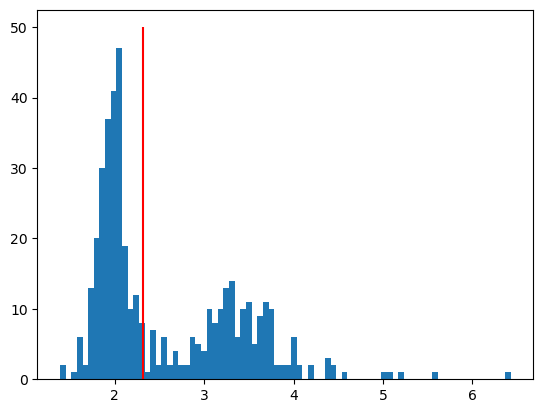

In [292]:
plt.hist(absolute_TCGA['ploidy'], bins=80)
plt.vlines([ma], color='r', ymin=0, ymax=50)
plt.show()

In [293]:
heterogeneity_y_ex = pd.qcut(mat_TCGA['heterogeneity'], 3, labels=['low', 'mid', 'high'])
heterogeneity_y_ex = heterogeneity_y_ex[heterogeneity_y_ex!='mid']
heterogeneity_y_ex = pd.DataFrame(index=heterogeneity_y_ex.index, columns=['dichtomized_heterogeneity'],
                               data=[int(p == 'high') 
                                     for p in heterogeneity_y_ex])

In [301]:
gm = GaussianMixture(n_components=2, random_state=0).fit(mat_TCGA['ploidy'].values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,mat_TCGA['ploidy'].max(),1000).reshape(-1,1))
ma = np.linspace(0,mat_TCGA['ploidy'].max(),1000)[y[:,1] < 0.5].max()
ploidy_y = pd.DataFrame(index=mat_TCGA.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in mat_TCGA['ploidy'].values])

In [295]:
ploidy_y_ex = pd.qcut(mat_TCGA['ploidy'], 3, labels=['low', 'mid', 'high'])
ploidy_y_ex = ploidy_y_ex[ploidy_y_ex!='mid']
ploidy_y_ex = pd.DataFrame(index=ploidy_y_ex.index, columns=['dichtomized_ploidy'],
                               data=[int(p == 'high') 
                                     for p in ploidy_y_ex])

## Train with run()

In [296]:
import Pnet

In [297]:
genetic_data = {'rna': skcm_exp, 'mut': mutations}

In [298]:
def fold_run(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=False)

        x_train = train_dataset.input_df.values
        additional_train = train_dataset.additional_data.values
        y_train = train_dataset.target.values.reshape(-1)
        x_test = test_dataset.input_df.values
        additional_test = test_dataset.additional_data.values
        y_test = test_dataset.target.values.reshape(-1)

        pred = model(torch.tensor(x_test, dtype=torch.float),
                                  torch.tensor(additional_test, dtype=torch.float)
                    )
        y_pred_proba = pred.detach().numpy().squeeze()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())

        aucs.append(test_auc)

        gene_importances, additional_importances = model.deepLIFT(test_dataset)
        most_imp_genes.append(gene_importances.sum().nlargest(20))
    return aucs, most_imp_genes

In [302]:
#heterogeneity_auc, heterogeneity_genes = fold_run(genetic_data, heterogeneity_y, 10)
#heterogeneity_ex_auc, heterogeneity_ex_genes = fold_run(genetic_data, heterogeneity_y_ex, 10)
ploidy_auc, ploidy_genes = fold_run(genetic_data, ploidy_y, 10)
#ploidy_ex_auc, ploidy_ex_genes = fold_run(genetic_data, ploidy_y_ex, 10)

run: 0
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 1
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 2
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 3
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 4
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 5
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 6
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 7
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 8
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 9
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


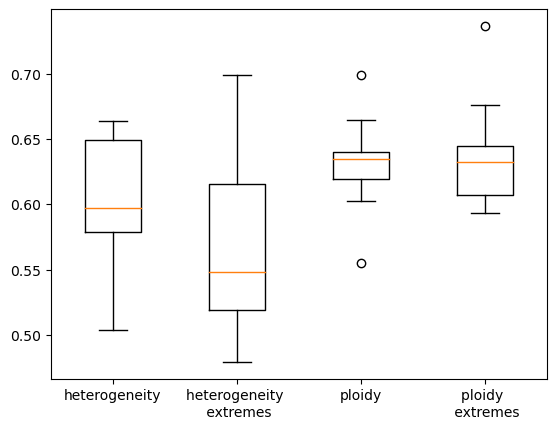

In [307]:
plt.boxplot([heterogeneity_auc, heterogeneity_ex_auc, ploidy_auc, ploidy_ex_auc],
            labels=['heterogeneity', 'heterogeneity \n extremes', 'ploidy', 'ploidy \n extremes'])
plt.show()

In [304]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.values
        additional_train = train_dataset.additional_data.values
        y_train = train_dataset.target.values.reshape(-1)
        x_test = test_dataset.input_df.values
        additional_test = test_dataset.additional_data.values
        y_test = test_dataset.target.values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns).nlargest(20, 0))
    return aucs, most_imp_genes

In [305]:
heterogeneity_auc, heterogeneity_genes_rf = fold_run_rf(genetic_data, heterogeneity_y, 10)
heterogeneity_ex_auc_rf, heterogeneity_ex_genes_rf = fold_run_rf(genetic_data, heterogeneity_y_ex, 10)
ploidy_auc_rf, ploidy_genes_rf = fold_run_rf(genetic_data, ploidy_y, 10)
ploidy_ex_auc_rf, ploidy_ex_genes_rf = fold_run_rf(genetic_data, ploidy_y_ex, 10)

run: 0
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
run: 1
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
run: 2
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
run: 3
Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapp

Found 675 overlapping genes
generated input DataFrame of size (196, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (84, 1350)
run: 2
Given 2 Input modalities
Found 280 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (196, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (84, 1350)
run: 3
Given 2 Input modalities
Found 280 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (196, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (84, 1350)
run: 4
Given 2 Input modalities
Found 280 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (196, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (84, 1350)
run: 5
Given 2 Input modalities
Found 

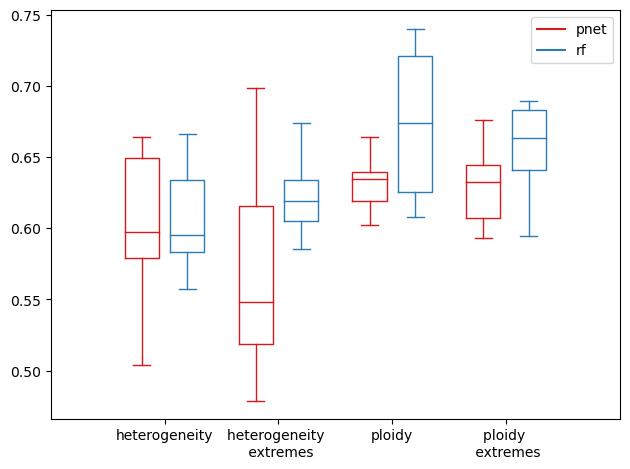

In [306]:
data_pnet = [heterogeneity_auc, heterogeneity_ex_auc, ploidy_auc, ploidy_ex_auc]
data_rf = [heterogeneity_auc_rf, heterogeneity_ex_auc_rf, ploidy_auc_rf, ploidy_ex_auc_rf]

ticks = ['heterogeneity', 'heterogeneity \n extremes', 'ploidy', 'ploidy \n extremes']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
    
bpl = plt.boxplot(data_pnet, positions=np.array(range(len(data_pnet)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_rf, positions=np.array(range(len(data_pnet)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='pnet')
plt.plot([], c='#2C7BB6', label='rf')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('heterogeneity_ploidy_auc_pnet_vs_rf.pdf')

In [117]:
ploidy_genes[0].index

Index(['FBXO47', 'TSSK1B', 'GPR52', 'ADPRHL2', 'RARRES1', 'ZBTB22', 'MACF1',
       'MEP1B', 'PLEKHH3', 'SPATS2L', 'ZNF878', 'HIST1H4C', 'SOCS7', 'FAM194A',
       'ZNF787', 'KIAA1109', 'BTBD8', 'KCTD16', 'MED8', 'FAM32A'],
      dtype='object')

In [124]:
gene_count_dict = {}
for r in ploidy_genes:
    for g in r.index:
        try:
            gene_count_dict[g] += 1
        except KeyError:
            gene_count_dict[g] = 1
pd.DataFrame.from_dict(gene_count_dict, orient='index').nlargest(10, 0)

,0
HIST1H4C,7
MEP1B,6
ZBTB22,5
CAGE1,5
GPR52,4
ADPRHL2,4
PRSS37,4
CXorf58,4
FBXO47,3
ARID3C,3


In [125]:
gene_count_dict = {}
for r in ploidy_genes_rf:
    for g in r.index:
        try:
            gene_count_dict[g] += 1
        except KeyError:
            gene_count_dict[g] = 1
pd.DataFrame.from_dict(gene_count_dict, orient='index').nlargest(10, 0)

,0
HSD17B12,9
KLHL23,7
NAPG,7
TMEM9B,7
DGKD,6
B4GALT3,6
ILVBL,4
DNMT3A,4
STK4,4
UBE2R2,4


In [299]:
ploidy_absolut_auc, ploidy_absolut_genes = fold_run(genetic_data, absolute_ploidy_y, 10)

run: 0
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 1
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 2
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 3
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 4
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 5
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 6
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 7
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 8
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 9
Given 2 Input modalities
Found 414 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (290, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (124, 1350)
Found 675 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


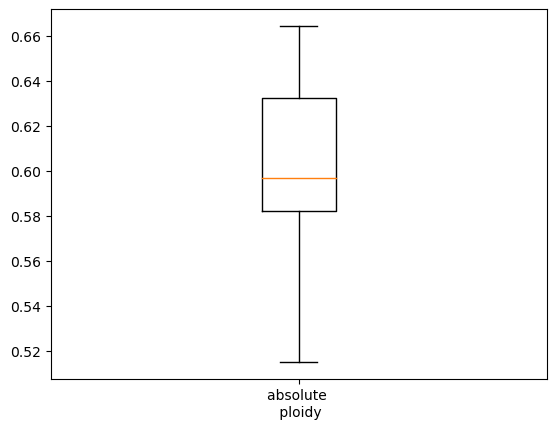

In [300]:
plt.boxplot(ploidy_absolut_auc,
            labels=['absolute \n ploidy'])
plt.show()

In [76]:
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         heterogeneity_y,
                                                                         verbose=False,
                                                                         early_stopping=False)

Given 2 Input modalities
Found 421 overlapping indicies
Initializing Train Dataset
Found 675 overlapping genes
generated input DataFrame of size (295, 1350)
Initializing Test Dataset
Found 675 overlapping genes
generated input DataFrame of size (126, 1350)
Found 675 overlapping genes


In [77]:
x_train = train_dataset.input_df.values
additional_train = train_dataset.additional_data.values
y_train = train_dataset.target.values.reshape(-1)
x_test = test_dataset.input_df.values
additional_test = test_dataset.additional_data.values
y_test = test_dataset.target.values.reshape(-1)

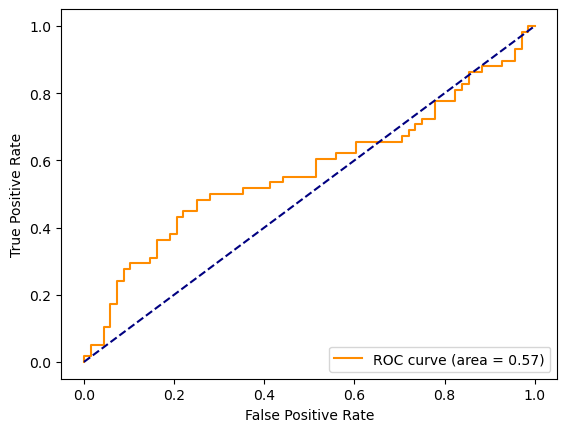

In [78]:
pred = model(torch.tensor(x_test, dtype=torch.float),
                          torch.tensor(additional_test, dtype=torch.float)
            )
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_heterogeneity_ROC_curve.pdf')
plt.show()

# Interpretability

## Gene level

### General correlations

In [79]:
from scipy.stats import pearsonr

In [88]:
input_df = pd.concat([train_dataset.input_df, test_dataset.input_df]).iloc[:,:int(1376/2)]
target_df = mat_TCGA.loc[input_df.index]
corr = []
for col in input_df.columns:
    r, p = pearsonr(input_df[col], target_df['ploidy'])
    corr.append((r,p))
heterog_corr = pd.DataFrame(corr, columns=['R', 'p_val'], index=input_df.columns)
heterog_corr['-log10_pval'] = -np.log10(heterog_corr['p_val'])

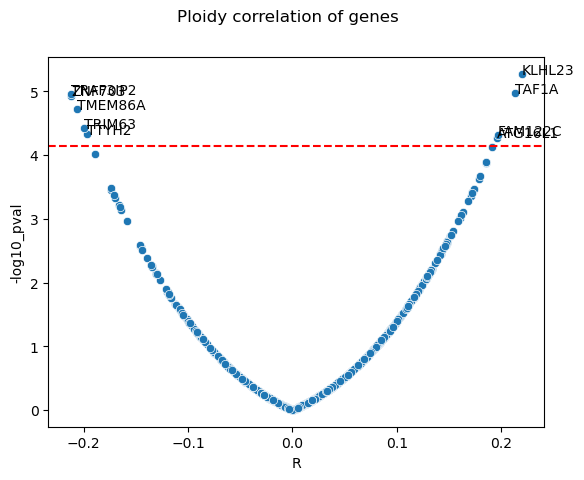

In [89]:
fig, ax = plt.subplots()
sns.scatterplot(heterog_corr, x='R', y='-log10_pval', ax=ax)
ax.axhline(y=-np.log10(0.05/heterog_corr.shape[0]), color='r', linestyle='--')


for gene in heterog_corr.index:
    if heterog_corr.loc[gene]['-log10_pval'] > -np.log10(0.05/heterog_corr.shape[0]):
        ax.annotate(gene, (heterog_corr.loc[gene]['R'], heterog_corr.loc[gene]['-log10_pval']))
fig.suptitle('Ploidy correlation of genes')
fig.savefig('Ploidy_correlation_genes.pdf')

In [90]:
heterog_corr.nlargest(10, 'R')

,R,p_val,-log10_pval
KLHL23,0.219754,0.000005,5.273195
TAF1A,0.212883,0.000011,4.976801
FAM122C,0.196729,0.000048,4.317214
ATG16L1,0.195647,0.000053,4.274879
ZACN,0.191657,0.000076,4.120719
IL1RAP,0.185530,0.000129,3.890047
SUMO2,0.185429,0.000130,3.886329
SP4,0.185264,0.000132,3.880217
CCDC142,0.179573,0.000212,3.672738
GABRA3,0.178456,0.000233,3.632723


### Pnet importances

In [83]:
gene_importances, additional_importances = model.deepLIFT(test_dataset)

/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [84]:
gene_imp_by_target = gene_importances.join(test_dataset.target).groupby('dichtomized_heterogeneity').mean().T
gene_imp_by_target['diff'] = abs(gene_imp_by_target[0] - gene_imp_by_target[1])

In [85]:
gene_imp_by_target[abs(gene_imp_by_target['diff']) > 0].nlargest(10, 'diff')

dichtomized_heterogeneity,0,1,diff
SH3GLB1,-0.073053,-0.033768,0.039284
ARID3C,-0.017910,0.001619,0.019529
CD200R1L,-0.054136,-0.039565,0.014572
BCL2L2,-0.032560,-0.018054,0.014505
IMPG1,0.035152,0.021860,0.013292
PM20D2,-0.024215,-0.011091,0.013124
TLCD1,0.002995,-0.010089,0.013085
C1orf198,-0.012366,0.000217,0.012583
BTBD9,0.031969,0.019549,0.012420
KIAA1467,-0.001347,-0.013307,0.011960


In [86]:
gene_importances.sum().nlargest(20)

ANP32D      8.746487
C12orf71    4.489496
BARHL1      4.385831
FAM78A      3.905925
IMPG1       3.658271
BTBD9       3.307747
TMEM86A     3.057227
ILVBL       2.997970
PATE2       2.913318
C22orf43    2.861485
MEGF8       2.840646
C10orf67    2.775090
GRASP       2.650676
FAM154A     2.592915
RPL6        2.460897
RBM11       2.384999
PAK1IP1     2.078421
TMEM62      2.042723
TMEM9B      1.587606
TSSK4       1.526687
dtype: float32

In [87]:
gene_impacts = pd.DataFrame()
gene_impacts['gene'] = rn.gene_list
gene_impacts['impact'] = gene_impacts['gene'].apply(lambda x: sum([l.loc[x].sum() for l in rn.gene_layers]))
gene_impacts['impact'].mean()

NameError: name 'rn' is not defined

In [ ]:
gene_impacts.nlargest(20, 'impact')

In [ ]:
flat_list = [item.split('_')[0] for sublist in altered_genes for item in sublist]
df = pd.DataFrame(index=flat_list)
df['gene_impact'] = gene_impacts.set_index('gene').loc[flat_list]['impact']
df['auc'] = aucs
df['most_imp_gene'] = most_imp_genes
df

In [ ]:
df = df.reset_index(names='gene')

In [ ]:
df_2 = pd.DataFrame()
df_2['gene_1'] = [x[0].split('_')[0] for x in altered_genes_2]
df_2['gene_2'] = [x[1].split('_')[0] for x in altered_genes_2]
df_2['gene_1_impact'] = gene_impacts.set_index('gene').loc[df_2['gene_1'].values]['impact'].values
df_2['gene_2_impact'] = gene_impacts.set_index('gene').loc[df_2['gene_2'].values]['impact'].values
df_2['auc_2'] = aucs_2
df_2['most_imp_gene_2'] = most_imp_genes_2
df_2

In [ ]:
df.join(df_2)

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(df.join(df_2)[['auc','auc_2']])
ax.set_xticklabels(['1 target gene','2 target genes'])
plt.savefig('AUC_with_perfectly_correlated_genes.pdf')

## Compare with Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
clf = RandomForestClassifier()
clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))

RandomForestClassifier()

In [93]:
test_acc = sum(clf.predict(test_dataset.input_df.values) == test_dataset.target.values.reshape(-1))/len(test_dataset)
test_acc

0.6190476190476191

In [94]:
pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns).nlargest(10, 0)

,0
PKN1,0.009412
SNTB1,0.007038
IGSF11,0.005487
UGT2B7,0.005362
DUSP16,0.005077
FUK,0.005070
ZIC1,0.005023
TESK2,0.004941
NAPG,0.004632
MAGEA3,0.004620


<AxesSubplot: xlabel='ZACN', ylabel='Count'>

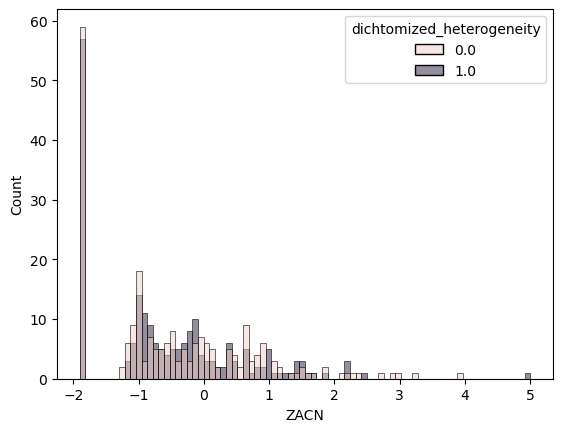

In [95]:
plot_df = skcm_exp.join(heterogeneity_y)
sns.histplot(plot_df, x='ZACN', hue='dichtomized_heterogeneity', bins=80)


In [96]:
importances_df = pd.DataFrame(index=heterog_corr.index)
importances_df['corr'] = heterog_corr['R']
importances_df['pnet_diff'] = gene_imp_by_target['diff'].loc[heterog_corr.index]
importances_df['pnet_sum'] = gene_importances.sum().loc[heterog_corr.index]

<AxesSubplot: xlabel='corr', ylabel='pnet_diff'>

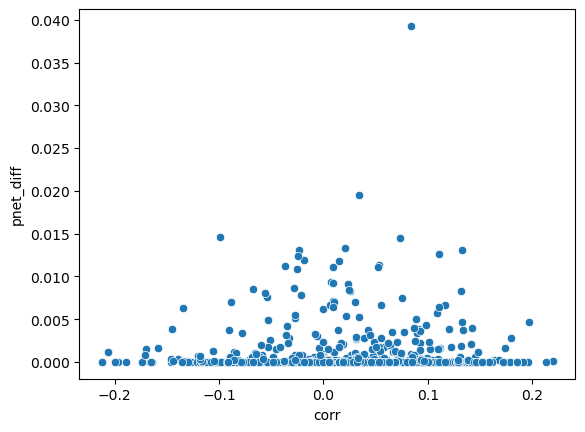

In [97]:
sns.scatterplot(importances_df, x='corr', y='pnet_diff')


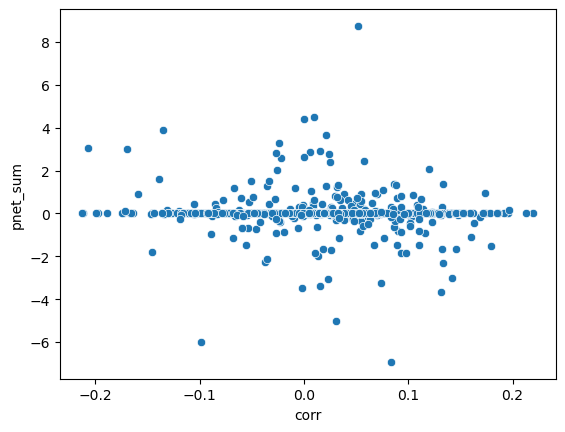

In [98]:
sns.scatterplot(importances_df, x='corr', y='pnet_sum')
plt.savefig('pnet_importance_vs_correlation.pdf')

<AxesSubplot: xlabel='pnet_diff', ylabel='pnet_sum'>

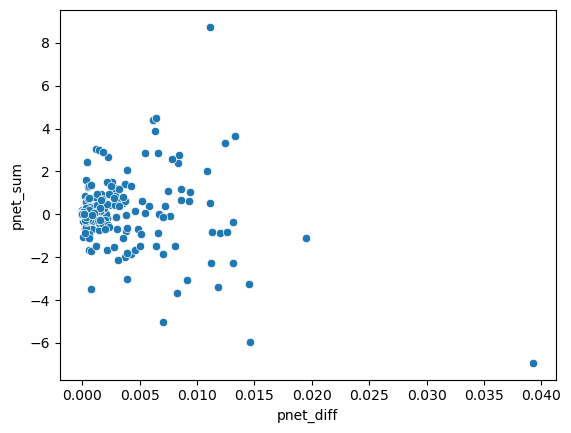

In [99]:
sns.scatterplot(importances_df, x='pnet_diff', y='pnet_sum')

## Pathway level

### General correlations

In [100]:
import gseapy as gp

In [101]:
ss = gp.ssgsea(data=input_df.T, 
               gene_sets='../data/reactome/ReactomePathways.gmt', 
               outdir='../ssgsea')

/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/gseapy/base.py:505: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, dd in res_df.groupby(["name"]):


In [102]:
pathway_scores = ss.res2d.pivot(index='Term', columns='Name', values='NES').T

In [103]:
target_df = mat_TCGA.loc[input_df.index]
corr = []
for col in pathway_scores.columns:
    r, p = pearsonr(pathway_scores[col], target_df['heterogeneity'])
    corr.append((r,p))
heterog_pathway_corr = pd.DataFrame(corr, columns=['R', 'p_val'], index=pathway_scores.columns)
heterog_pathway_corr['-log10_pval'] = -np.log10(heterog_pathway_corr['p_val'])

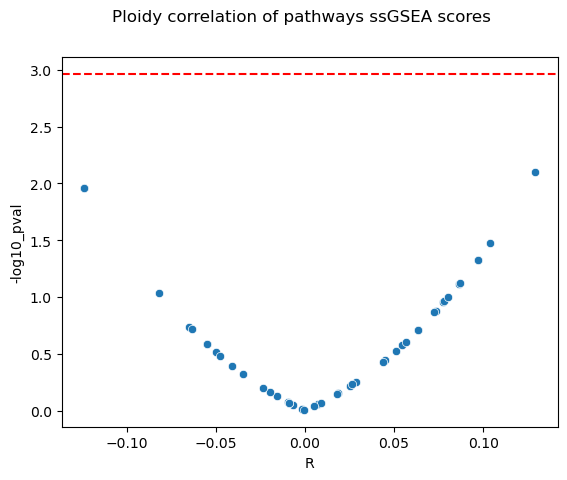

In [104]:
fig, ax = plt.subplots()
sns.scatterplot(heterog_pathway_corr, x='R', y='-log10_pval', ax=ax)
ax.axhline(y=-np.log10(0.05/heterog_pathway_corr.shape[0]), color='r', linestyle='--')


for gene in heterog_pathway_corr.index:
    if heterog_pathway_corr.loc[gene]['-log10_pval'] > -np.log10(0.05/heterog_pathway_corr.shape[0]):
        ax.annotate(gene, (heterog_pathway_corr.loc[gene]['R'], heterog_pathway_corr.loc[gene]['-log10_pval']))
        
fig.suptitle('Ploidy correlation of pathways ssGSEA scores')
fig.savefig('Ploidy_correlation_pathways.pdf')

In [105]:
abs(heterog_pathway_corr).nlargest(20, 'R')

,R,p_val,-log10_pval
Term,,,
Metabolism of proteins,0.129068,0.008014,2.096163
GPCR downstream signalling,0.123905,0.010941,1.960940
Signaling by GPCR,0.123905,0.010941,1.960940
Post-translational protein modification,0.103694,0.033416,1.476040
Antigen processing: Ubiquitination & Proteasome degradation,0.096816,0.047115,1.326840
Class I MHC mediated antigen processing & presentation,0.096816,0.047115,1.326840
Metabolism of RNA,0.086823,0.075153,1.124053
"Cell Cycle, Mitotic",0.086392,0.076618,1.115667
G alpha (i) signalling events,0.082021,0.092810,1.032406


### Pnet pathway importances

In [ ]:
pathway_importances = model.layerwise_importance(test_dataset)

In [ ]:
pathway_importances[-1].nlargest(20, 'diff')

In [ ]:
test_df = test_dataset.target
test_df['pred'] = pred.round().detach().numpy()
test_df['missclass'] = abs(test_df['dichtomized_heterogeneity'] - test_df['pred'])
test_df[test_df['missclass'] > 0].index

In [ ]:
sns.histplot(mat_TCGA.join(test_df), x='heterogeneity', hue='missclass', bins=30)

In [ ]:
pred.detach().round().mean()

## Train with Lightning

In [ ]:
%cd src
import Pnet
import ReactomeNetwork

In [ ]:
import pytorch_lightning as pl

In [ ]:
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

In [ ]:
model = Pnet.PNET_NN(hparams=
                     {'reactome_network':reactome_network, 'nbr_gene_inputs':len(genetic_data), 'dropout':0.2,
                      'additional_dims':0, 'lr':1e-3, 'weight_decay':1e-5}
                    )

In [ ]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 56)

In [ ]:
batch_x, additional, batch_y = next(iter(train_loader))

In [ ]:
additional.shape

In [ ]:
trainer = pl.Trainer(precision=16, accelerator=None, max_epochs=100, log_every_n_steps=50, 
                     enable_checkpointing=False)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,)